# Analysis of the attack on Diva without clustering before the construction of the blackbox

For this attack I used adaboost instead of the random forests both for the shadow models and the attack models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from pathlib import Path
import os
import sys
import bz2
import pickle
np.random.seed(10)
# adds the visibility of the mlem module, needed to load the attack models
sys.path.append("../../../../..") 
import mlem
from mlem.ensemble import HardVotingClassifier

In [2]:
import warnings

In [3]:
BLACK_BOX_PATH = '../BB_DATA/diva_rf_noclustering.bz2'

In [4]:
def get_attack_mod(index:int, targets=[0,1], base_folder=None):
    """
    Args:
        index - row of the dataset on which the attack model was built
        targets (int | List(int)) - targets for the attack model.
    Returns:
        List containing the attack models (or model) for that particular index
    """
    if type(targets) is int:
        targets = [targets]
    loaded_models = []
    for t in targets:
        path = f"{base_folder}/{index}/attack/{t}/model.pkl.bz2"
        with bz2.BZ2File(path) as f:
            data = pickle.load(f)
            loaded_models.append(data)
    return loaded_models
        

def split_probs_array(arr):
    """
    
    """
    n_classes = len(arr[0])
    separated = []
    max_index_row = np.argmax(arr, axis=1)
    for c in range(n_classes):
        separated.append(arr[max_index_row == c])
    return separated

In [5]:
with bz2.BZ2File(BLACK_BOX_PATH) as f:
    black_box = pickle.load(f)
black_box

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=100,
                       min_samples_leaf=10, min_samples_split=10,
                       n_estimators=150)

# Attack

In [6]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [8]:
BASE_BB_DATA_PATH = "../BB_DATA/diva_rf_noclustering_data_nsamples_{n_samples}.npz"

## $5$ elements per quantile

In [9]:
BB_DATA = "../BB_DATA/clusters_representatives_quantiles_5_40.csv"

In [10]:
loaded = np.load(BASE_BB_DATA_PATH.format(n_samples=5), allow_pickle=True)
for k in loaded.keys():
    print(k, end=" ")
x_train = loaded["x_train"]
x_test = loaded["x_test"]
y_train = loaded["y_train"]
y_test = loaded["y_test"]
x_test_clustered = loaded["x_test_clustered"]
y_test_clustered = loaded["y_test_clustered"]

x_train x_test y_train y_test x_test_clustered y_test_clustered 

In [11]:
ATTACK_0, ATTACK_1 = [], []

for index in range(len(x_test_clustered)):
    atk0, atk1 = get_attack_mod(index, base_folder="/home/gerardozinno/Desktop/ExperimentsResult/ADA/DIVA/diva_results_noclust_5/gaussian/same")
    ATTACK_0.append(atk0)
    ATTACK_1.append(atk1)
assert (len(ATTACK_0) == len(ATTACK_1)) and (len(ATTACK_0) == len(x_test_clustered))
        
ensemble_0 = HardVotingClassifier(classifiers=ATTACK_0)
ensemble_1 = HardVotingClassifier(classifiers=ATTACK_1)

/home/gerardozinno/.pyenv/versions/ml-environment/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/gerardozinno/.pyenv/versions/ml-environment/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator AdaBoostClassifier from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [12]:
TRAIN_PREDICTIONS = black_box.predict_proba(x_train)
TEST_PREDICTIONS  = black_box.predict_proba(x_test)

In [13]:
TRAIN_0, TRAIN_1 = split_probs_array(TRAIN_PREDICTIONS)
TEST_0, TEST_1  = split_probs_array(TEST_PREDICTIONS)

In [14]:
IN_0 = ensemble_0.predict(TRAIN_0)
IN_1 = ensemble_1.predict(TRAIN_1)
OUT_0 = ensemble_0.predict(TEST_0)
OUT_1 = ensemble_1.predict(TEST_1)

In [15]:
INS = np.concatenate([IN_0, IN_1])
INS_LAB = np.array(["in"] * len(INS))
OUTS = np.concatenate([OUT_0, OUT_1])
OUTS_LAB = np.array(["out"] * len(OUTS))

In [16]:
number_even_in = len([x for x in INS if x == "even"])
number_even_out = len([x for x in OUTS if x == "even"])
print(f"even_in = {number_even_in/len(INS)}")
print(F"even_out = {number_even_out/len(OUTS)}")

even_in = 0.0
even_out = 0.0


In [17]:
INOUT = np.concatenate([INS, OUTS])
INOUT_LAB = np.concatenate([INS_LAB, OUTS_LAB])

In [20]:
print(classification_report(INOUT_LAB, INOUT))

              precision    recall  f1-score   support

          in       0.70      1.00      0.82      6624
         out       0.00      0.00      0.00      2839

    accuracy                           0.70      9463
   macro avg       0.35      0.50      0.41      9463
weighted avg       0.49      0.70      0.58      9463



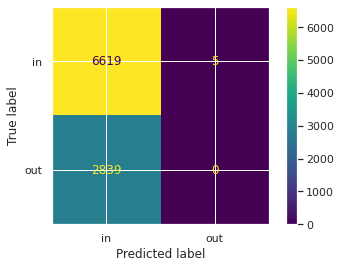

In [21]:
ConfusionMatrixDisplay.from_predictions(INOUT_LAB, INOUT)

## $7$ elements per quantile

In [22]:
BB_DATA = "../BB_DATA/clusters_representatives_quantiles_7_56.csv"

In [23]:
loaded = np.load(BASE_BB_DATA_PATH.format(n_samples=7), allow_pickle=True)
for k in loaded.keys():
    print(k, end=" ")
x_train = loaded["x_train"]
x_test = loaded["x_test"]
y_train = loaded["y_train"]
y_test = loaded["y_test"]
x_test_clustered = loaded["x_test_clustered"]
y_test_clustered = loaded["y_test_clustered"]

x_train x_test y_train y_test x_test_clustered y_test_clustered 

In [24]:
ATTACK_0, ATTACK_1 = [], []

for index in range(len(x_test_clustered)):
    atk0, atk1 = get_attack_mod(index, base_folder="/home/gerardozinno/Desktop/ExperimentsResult/ADA/DIVA/diva_results_noclust_7/gaussian/same")
    ATTACK_0.append(atk0)
    ATTACK_1.append(atk1)
assert (len(ATTACK_0) == len(ATTACK_1)) and (len(ATTACK_0) == len(x_test_clustered))
        
ensemble_0 = HardVotingClassifier(classifiers=ATTACK_0)
ensemble_1 = HardVotingClassifier(classifiers=ATTACK_1)

/home/gerardozinno/.pyenv/versions/ml-environment/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/gerardozinno/.pyenv/versions/ml-environment/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator AdaBoostClassifier from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [25]:
TRAIN_PREDICTIONS = black_box.predict_proba(x_train)
TEST_PREDICTIONS  = black_box.predict_proba(x_test)

In [26]:
TRAIN_0, TRAIN_1 = split_probs_array(TRAIN_PREDICTIONS)
TEST_0, TEST_1  = split_probs_array(TEST_PREDICTIONS)

In [27]:
IN_0 = ensemble_0.predict(TRAIN_0)
IN_1 = ensemble_1.predict(TRAIN_1)
OUT_0 = ensemble_0.predict(TEST_0)
OUT_1 = ensemble_1.predict(TEST_1)

In [28]:
INS = np.concatenate([IN_0, IN_1])
INS_LAB = np.array(["in"] * len(INS))
OUTS = np.concatenate([OUT_0, OUT_1])
OUTS_LAB = np.array(["out"] * len(OUTS))

In [29]:
number_even_in = len([x for x in INS if x == "even"])
number_even_out = len([x for x in OUTS if x == "even"])
print(f"even_in = {number_even_in/len(INS)}")
print(F"even_out = {number_even_out/len(OUTS)}")

even_in = 0.0
even_out = 0.0


In [30]:
INOUT = np.concatenate([INS, OUTS])
EVEN_MASK = INOUT != "even" # to mask away the even values
INOUT_LAB = np.concatenate([INS_LAB, OUTS_LAB])

In [31]:
print(classification_report(INOUT_LAB[EVEN_MASK], INOUT[EVEN_MASK]))

              precision    recall  f1-score   support

          in       0.70      1.00      0.82      6624
         out       0.00      0.00      0.00      2839

    accuracy                           0.70      9463
   macro avg       0.35      0.50      0.41      9463
weighted avg       0.49      0.70      0.58      9463



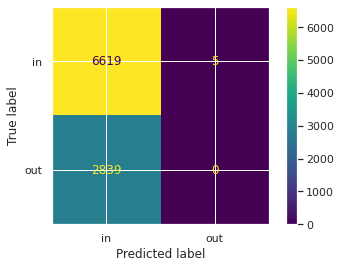

In [32]:
ConfusionMatrixDisplay.from_predictions(INOUT_LAB[EVEN_MASK], INOUT[EVEN_MASK])

## $9$ elements per quantile

In [33]:
BB_DATA = "../BB_DATA/clusters_representatives_quantiles_9_72.csv"

In [34]:
loaded = np.load(BASE_BB_DATA_PATH.format(n_samples=9), allow_pickle=True)
for k in loaded.keys():
    print(k, end=" ")
x_train = loaded["x_train"]
x_test = loaded["x_test"]
y_train = loaded["y_train"]
y_test = loaded["y_test"]
x_test_clustered = loaded["x_test_clustered"]
y_test_clustered = loaded["y_test_clustered"]

x_train x_test y_train y_test x_test_clustered y_test_clustered 

In [35]:
ATTACK_0, ATTACK_1 = [], []

for index in range(len(x_test_clustered)):
    atk0, atk1 = get_attack_mod(index, base_folder="/home/gerardozinno/Desktop/ExperimentsResult/ADA/DIVA/diva_results_noclust_ada_9/gaussian/same")
    ATTACK_0.append(atk0)
    ATTACK_1.append(atk1)
assert (len(ATTACK_0) == len(ATTACK_1)) and (len(ATTACK_0) == len(x_test_clustered))
        
ensemble_0 = HardVotingClassifier(classifiers=ATTACK_0)
ensemble_1 = HardVotingClassifier(classifiers=ATTACK_1)

In [36]:
TRAIN_PREDICTIONS = black_box.predict_proba(x_train)
TEST_PREDICTIONS  = black_box.predict_proba(x_test)

In [37]:
TRAIN_0, TRAIN_1 = split_probs_array(TRAIN_PREDICTIONS)
TEST_0, TEST_1  = split_probs_array(TEST_PREDICTIONS)

In [38]:
IN_0 = ensemble_0.predict(TRAIN_0)
IN_1 = ensemble_1.predict(TRAIN_1)
OUT_0 = ensemble_0.predict(TEST_0)
OUT_1 = ensemble_1.predict(TEST_1)

In [39]:
INS = np.concatenate([IN_0, IN_1])
INS_LAB = np.array(["in"] * len(INS))
OUTS = np.concatenate([OUT_0, OUT_1])
OUTS_LAB = np.array(["out"] * len(OUTS))

In [40]:
number_even_in = len([x for x in INS if x == "even"])
number_even_out = len([x for x in OUTS if x == "even"])
print(f"even_in = {number_even_in/len(INS)}")
print(F"even_out = {number_even_out/len(OUTS)}")

even_in = 0.00015096618357487922
even_out = 0.0


In [41]:
INOUT = np.concatenate([INS, OUTS])
EVEN_MASK = INOUT != "even" # to mask away the even values
INOUT_LAB = np.concatenate([INS_LAB, OUTS_LAB])

In [42]:
print(classification_report(INOUT_LAB[EVEN_MASK], INOUT[EVEN_MASK]))

              precision    recall  f1-score   support

          in       0.70      1.00      0.82      6623
         out       0.00      0.00      0.00      2839

    accuracy                           0.70      9462
   macro avg       0.35      0.50      0.41      9462
weighted avg       0.49      0.70      0.58      9462



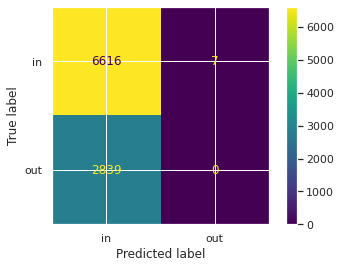

In [43]:
ConfusionMatrixDisplay.from_predictions(INOUT_LAB[EVEN_MASK], INOUT[EVEN_MASK])